#Pitch Classification Models

https://github.com/brettcastro2004/Pitch-Classification-Model


This is a pitch classification model featuring data cleaning, normalization, correlation and feature visualization, KNN, ANN, PCA, and an ensemble model.
This model was created by Brett Castro and Paulo Julio. See the github link above for more information and dataset access.

In [1]:
# Importing all libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


#Data Gathering & Normalization


In [2]:
folder_path = "/content/data"

columns_needed = [
    "pitch_type",
    "player_name",
    "release_speed",
    "pfx_x",
    "pfx_z",
    "release_spin_rate",
    "spin_axis",
    "p_throws"
]

hand_col = "p_throws" # Handedness indicator
spin_col = "spin_axis"

numeric_columns = [
    "release_speed",
    "pfx_x",
    "pfx_z",
    "release_spin_rate",
    "spin_axis"
]

csv_files = [
    "four_seam_fastball_data.csv",
    "cutter_data.csv",
    "changeup_data.csv",
    "curveball_data.csv",
    "sinker_data.csv",
    "slider_data.csv",
    "splitter_data.csv",
    "sweeper_data.csv"
]

output_csv = 'normalized_pitch_data.csv'

df = pd.DataFrame()

NUM_ROWS = 5000  # Desired rows per pitch type

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    print(f"\nProcessing: {file}")

    clean_rows = []

    # Read in chunks of 1000 rows to ensure 5000 of each type
    file_chunk = pd.read_csv(file_path, chunksize=1000)

    # Clean data
    for chunk in file_chunk:
        chunk = chunk[columns_needed]
        chunk = chunk.replace([float("inf"), float("-inf")], pd.NA)
        chunk = chunk.dropna()
        clean_rows.append(chunk)

        # Stop if we have enough clean rows (5000)
        total_clean = sum(len(x) for x in clean_rows)
        if total_clean >= NUM_ROWS:
            break

    combined = pd.concat(clean_rows, ignore_index=True)

    # Enforce EXACTLY 5000 rows
    combined = combined.head(NUM_ROWS)
    print(f"Clean rows collected: {len(combined)}")
    df = pd.concat([df, combined], ignore_index=True)

# Normalize handedness (mirror lefties)
left_mask = df[hand_col].str.upper() == "L"
df.loc[left_mask, "pfx_x"] = -df.loc[left_mask, "pfx_x"]

# Mirror spin axis: new_axis = (360 - old_axis) % 360
df.loc[left_mask, spin_col] = (360 - df.loc[left_mask, spin_col]) % 360

print(f"\nPitches mirrored: {left_mask.sum()}")

# Keep an unnormalized dataframe for feature analysis
unnorm_df = df.copy(deep=True)

# Normalize numeric features (z-score)
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Save dataframe to csv
df.to_csv(output_csv, index=False)
print(f"Saved to: {output_csv}")



Processing: four_seam_fastball_data.csv
Clean rows collected: 5000

Processing: cutter_data.csv
Clean rows collected: 5000

Processing: changeup_data.csv
Clean rows collected: 5000

Processing: curveball_data.csv
Clean rows collected: 5000

Processing: sinker_data.csv
Clean rows collected: 5000

Processing: slider_data.csv
Clean rows collected: 5000

Processing: splitter_data.csv
Clean rows collected: 5000

Processing: sweeper_data.csv
Clean rows collected: 5000

Pitches mirrored: 10721
Saved to: normalized_pitch_data.csv


# Dataset Analysis and Visualization


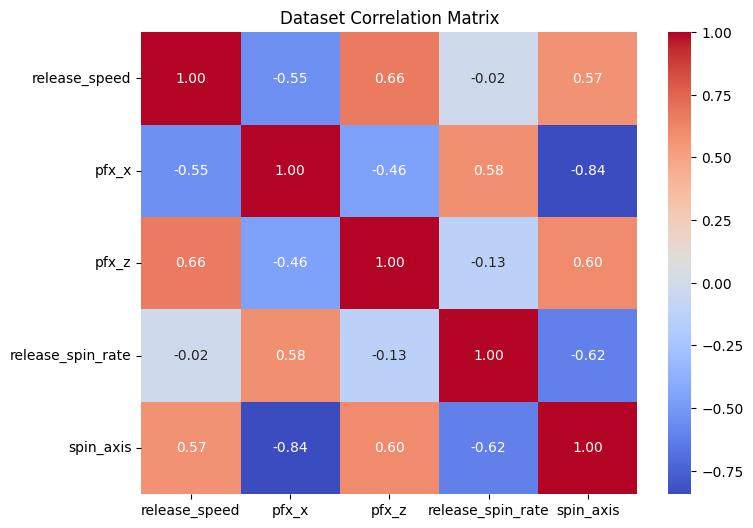

In [3]:
# Create correlation matrix plot
plt.figure(figsize=(8,6))
corr = df[numeric_columns].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Dataset Correlation Matrix")
plt.show()

# Spin Axis vs Horizontal Break


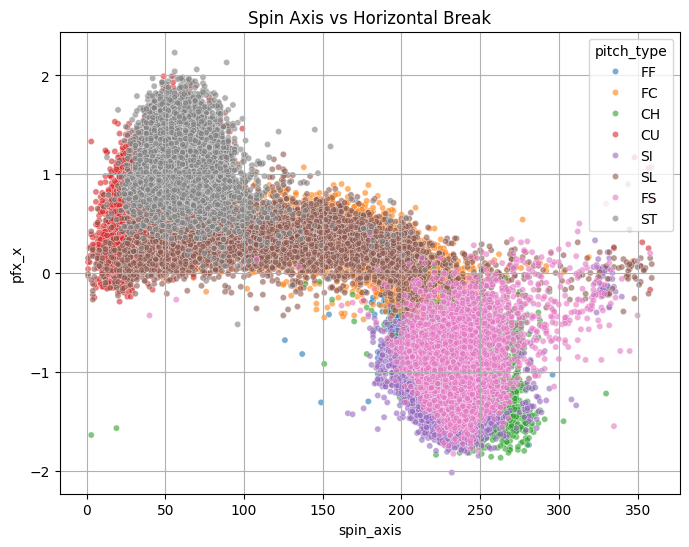

In [4]:
# We examine the effect of spin axis on horizontal movement

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=unnorm_df,
    x="spin_axis",
    y="pfx_x",
    hue="pitch_type",
    alpha=0.6,
    s=20
)
plt.title("Spin Axis vs Horizontal Break")
plt.grid(True)
plt.show()

# Velocity vs Vertical Movement



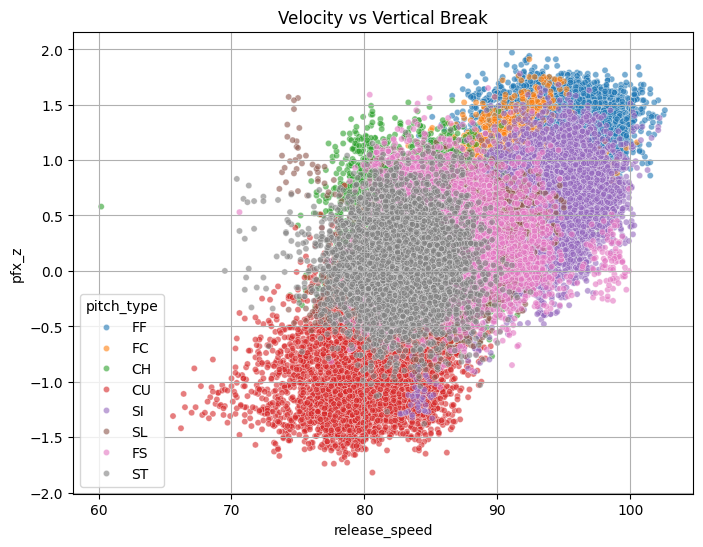

In [5]:
# We examine the relationship between velocity and vertical movement

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=unnorm_df,
    x="release_speed",
    y="pfx_z",
    hue="pitch_type",
    alpha=0.6,
    s=20
)
plt.title("Velocity vs Vertical Break")
plt.grid(True)
plt.show()


# Spin Rate vs Induced Break



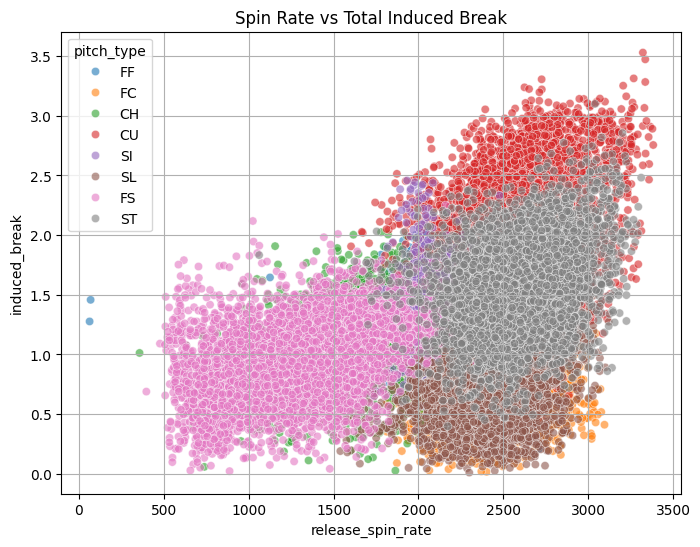

In [ ]:
# We examine the relationship between total induced break and spin rate

unnorm_df["induced_break"] = np.sqrt(df["pfx_x"]**2 + df["pfx_z"]**2)

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=unnorm_df,
    x="release_spin_rate",
    y="induced_break",
    hue="pitch_type",
    alpha=0.6
)
plt.title("Spin Rate vs Total Induced Break")
plt.grid(True)
plt.show()



---


# Training a Model


In [28]:
plt.rcParams['figure.dpi'] = 140

X = df[numeric_columns].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["pitch_type"])

classes = label_encoder.classes_
num_classes = len(classes)

# Training split - 4000 training, 1000 testing per pitch type
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## K Nearest Neighbors (KNN)



In [29]:
knn = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance",
    metric="euclidean"
)

knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average='macro')
rec_knn = recall_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')


print(f"\nKNN Accuracy: {acc_knn:.4f}")
print(f"KNN Precision:, {prec_knn:.4f}")
print(f"KNN Recall:, {rec_knn:.4f}")
print(f"KNN F1-score:, {f1_knn:.4f}")

print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=classes))



KNN Accuracy: 0.8340
KNN Precision:, 0.8333
KNN Recall:, 0.8340
KNN F1-score:, 0.8332

Classification Report (KNN):
              precision    recall  f1-score   support

          CH       0.78      0.76      0.77      1000
          CU       0.91      0.90      0.91      1000
          FC       0.79      0.81      0.80      1000
          FF       0.92      0.93      0.92      1000
          FS       0.80      0.82      0.81      1000
          SI       0.91      0.89      0.90      1000
          SL       0.74      0.67      0.70      1000
          ST       0.83      0.89      0.86      1000

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



<Figure size 1120x840 with 0 Axes>

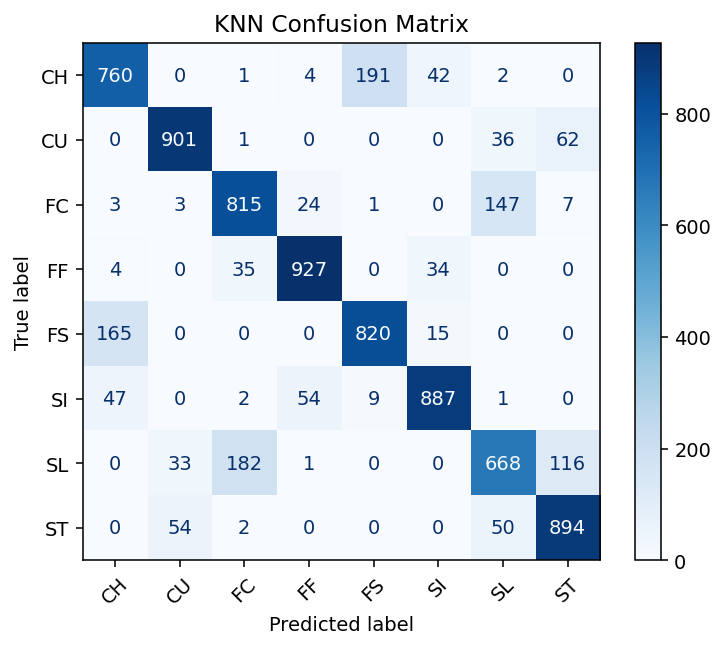

In [30]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("KNN Confusion Matrix")
plt.show()

# KNN Optimization


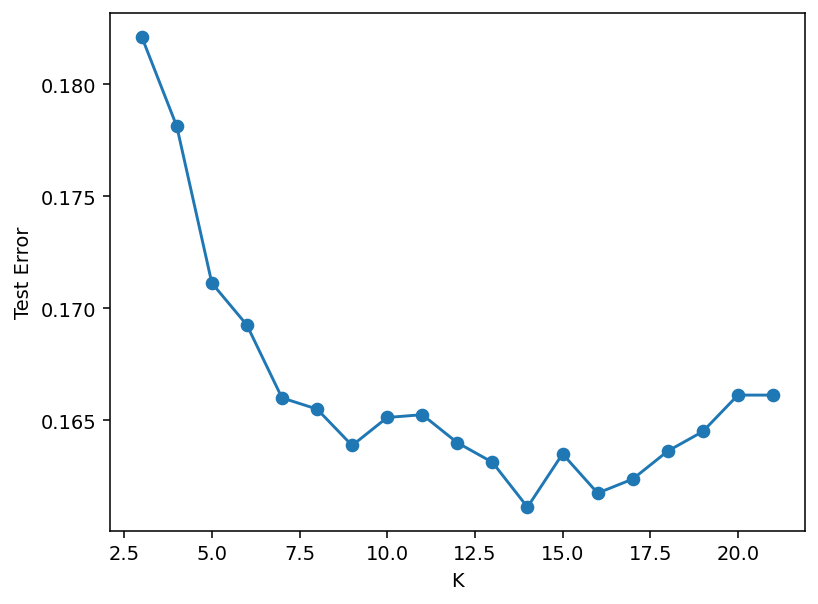

Best K: 14

KNN Accuracy: 0.8389
KNN Precision: 0.8381
KNN Recall: 0.8389
KNN F1-score: 0.8378

Classification Report (KNN):
              precision    recall  f1-score   support

          CH       0.79      0.76      0.78      1000
          CU       0.92      0.90      0.91      1000
          FC       0.79      0.82      0.80      1000
          FF       0.92      0.93      0.92      1000
          FS       0.82      0.83      0.82      1000
          SI       0.90      0.89      0.90      1000
          SL       0.75      0.67      0.71      1000
          ST       0.83      0.91      0.87      1000

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



In [31]:
# Test multiple K values for parameter optimization to find best K. Plot the test error vs K and look for elbow. Print classification report for that K.
K = list(range(3,22))
E = []

for k in K:
    m = KNeighborsClassifier(n_neighbors=k, weights="distance", metric="euclidean")
    m.fit(X_train_scaled, y_train)
    p = m.predict(X_test_scaled)
    E.append(1 - accuracy_score(y_test, p))

plt.plot(K, E, marker='o')
plt.xlabel("K")
plt.ylabel("Test Error")
plt.show()

best_k = K[E.index(min(E))]

knn = KNeighborsClassifier(n_neighbors=best_k, weights="distance", metric="euclidean")
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn, average='macro')
rec_knn = recall_score(y_test, y_pred_knn, average='macro')
f1_knn = f1_score(y_test, y_pred_knn, average='macro')

print("Best K:", best_k)
print(f"\nKNN Accuracy: {acc_knn:.4f}")
print(f"KNN Precision: {prec_knn:.4f}")
print(f"KNN Recall: {rec_knn:.4f}")
print(f"KNN F1-score: {f1_knn:.4f}")
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred_knn, target_names=classes))


<Figure size 1120x840 with 0 Axes>

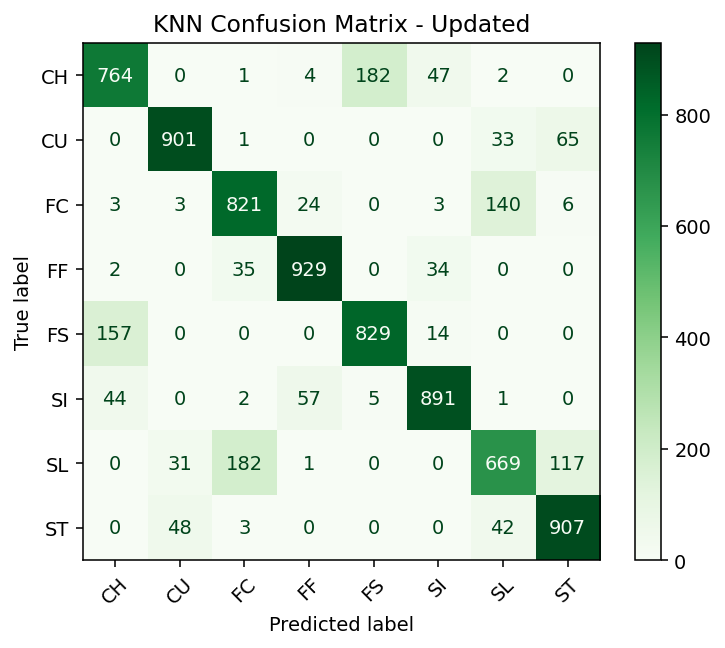

In [32]:
cm_knn = confusion_matrix(y_test, y_pred_knn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Greens", xticks_rotation=45)
plt.title("KNN Confusion Matrix - Updated")
plt.show()

# Artificial Neural Network (ANN)


In [11]:
# Begin by resetting training split for ANN

X = df[numeric_columns].values

# One hot encode pitch type for ANN
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(df["pitch_type"])
y = tf.keras.utils.to_categorical(y_int, num_classes=len(label_encoder.classes_))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y_int
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
# Create model based off of sample code, modified to our application

ann = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(len(label_encoder.classes_), activation='softmax')
])

ann.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Build model and run

history = ann.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6977 - loss: 0.3878 - val_accuracy: 0.8042 - val_loss: 0.1213
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7837 - loss: 0.1328 - val_accuracy: 0.8078 - val_loss: 0.1136
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7897 - loss: 0.1259 - val_accuracy: 0.8125 - val_loss: 0.1093
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8016 - loss: 0.1203 - val_accuracy: 0.8130 - val_loss: 0.1075
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8019 - loss: 0.1189 - val_accuracy: 0.8117 - val_loss: 0.1077
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7960 - loss: 0.1186 - val_accuracy: 0.8141 - val_loss: 0.1072
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8033 - loss: 0.1166 - val_accuracy: 0.8078 - val_loss: 0.1100
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8030 - loss: 0.1154 - val_accu

In [16]:
test_loss, test_acc = ann.evaluate(X_test, y_test, verbose=0)
print(f"\nANN Test Accuracy: {test_acc:.4f}")

y_pred_ann = ann.predict(X_test)
y_pred_labels_ann = np.argmax(y_pred_ann, axis=1)
y_true_labels_ann = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_labels_ann, y_pred_labels_ann, target_names=label_encoder.classes_))



ANN Test Accuracy: 0.8316
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

          CH       0.77      0.77      0.77      1000
          CU       0.92      0.89      0.90      1000
          FC       0.74      0.85      0.79      1000
          FF       0.92      0.92      0.92      1000
          FS       0.81      0.82      0.81      1000
          SI       0.92      0.87      0.90      1000
          SL       0.76      0.63      0.69      1000
          ST       0.83      0.91      0.87      1000

    accuracy                           0.83      8000
   macro avg       0.83      0.83      0.83      8000
weighted avg       0.83      0.83      0.83      8000



<Figure size 1120x840 with 0 Axes>

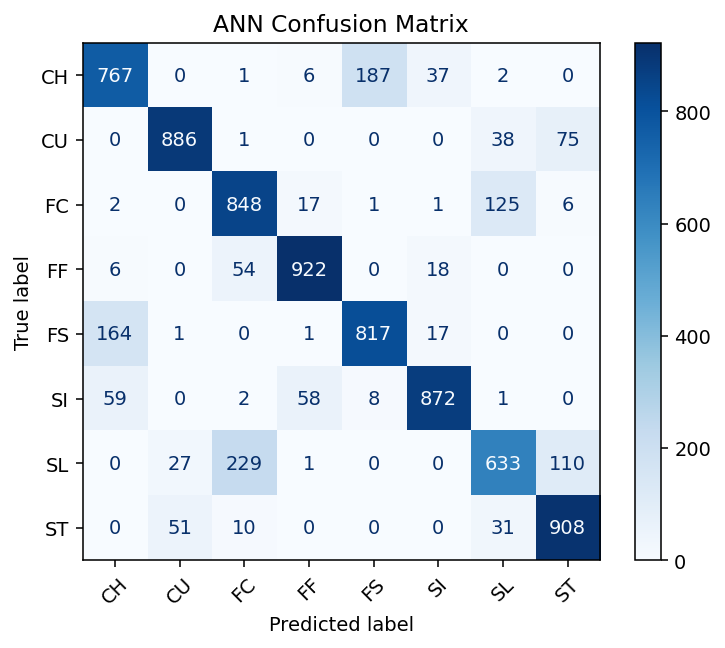

In [17]:
cm_ann = confusion_matrix(y_true_labels_ann, y_pred_labels_ann)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann, display_labels=classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("ANN Confusion Matrix")
plt.show()

#PCA (Principal Component Analysis)

In [18]:
X = df[numeric_columns].values

label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(df["pitch_type"])
y = tf.keras.utils.to_categorical(y_int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y_int
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# PCA to 2 components
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_s)
X_test_pca  = pca.transform(X_test_s)

In [20]:
knn_pca = KNeighborsClassifier(
    n_neighbors=14,
    weights="distance",
    metric="euclidean"
    )
knn_pca.fit(X_train_pca, np.argmax(y_train, axis=1))

y_pred_knn_pca = knn_pca.predict(X_test_pca)

acc_knn_pca = accuracy_score(np.argmax(y_test, axis=1), y_pred_knn_pca)
print(f"\nKNN PCA Accuracy: {acc_knn_pca:.4f}")


print("\nClassification Report (KNN PCA):")
print(classification_report(np.argmax(y_test, axis=1), y_pred_knn_pca, target_names=classes))


KNN PCA Accuracy: 0.6751

Classification Report (KNN PCA):
              precision    recall  f1-score   support

          CH       0.58      0.60      0.59      1000
          CU       0.79      0.78      0.79      1000
          FC       0.72      0.74      0.73      1000
          FF       0.75      0.72      0.73      1000
          FS       0.69      0.67      0.68      1000
          SI       0.65      0.69      0.67      1000
          SL       0.60      0.54      0.57      1000
          ST       0.62      0.67      0.64      1000

    accuracy                           0.68      8000
   macro avg       0.68      0.68      0.67      8000
weighted avg       0.68      0.68      0.67      8000



<Figure size 1120x840 with 0 Axes>

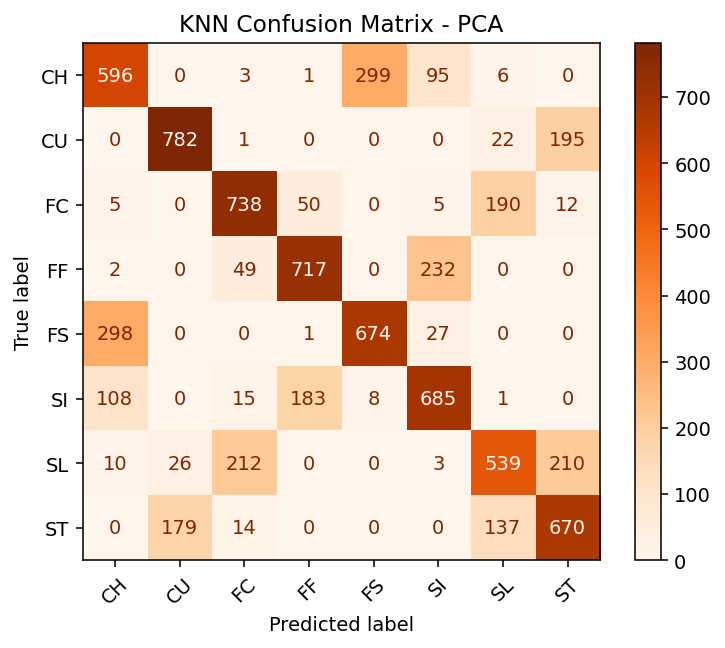

In [21]:
cm_knn = confusion_matrix(np.argmax(y_test, axis=1), y_pred_knn_pca)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("KNN Confusion Matrix - PCA")
plt.show()

In [ ]:
# Same ANN config as before
ann_pca = Sequential([
    Dense(128, activation='relu', input_shape=(2,)),
    BatchNormalization(),
    Dropout(0.1),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(32, activation='relu'),
    BatchNormalization(),

    Dense(len(label_encoder.classes_), activation='softmax')

])

ann_pca.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_pca = ann_pca.fit(
    X_train_pca, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6077 - loss: 0.4229 - val_accuracy: 0.6919 - val_loss: 0.1659
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6709 - loss: 0.1783 - val_accuracy: 0.6998 - val_loss: 0.1603
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6716 - loss: 0.1752 - val_accuracy: 0.6986 - val_loss: 0.1602
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6693 - loss: 0.1737 - val_accuracy: 0.6986 - val_loss: 0.1573
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6786 - loss: 0.1698 - val_accuracy: 0.7009 - val_loss: 0.1582
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6746 - loss: 0.1705 - val_accuracy: 0.6988 - val_loss: 0.1574
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6779 - loss: 0.1692 - val_accuracy: 0.6977 - val_loss: 0.1561
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6742 - loss: 0.1696 - val_accuracy: 0.6980

In [ ]:
test_loss, test_acc = ann_pca.evaluate(X_test_pca, y_test, verbose=0)
print(f"\nANN PCA Accuracy: {test_acc:.4f}")

y_pred_ann_pca = ann_pca.predict(X_test_pca)
y_pred_labels_ann_pca = np.argmax(y_pred_ann_pca, axis=1)
y_true_labels_ann_pca = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_labels_ann_pca, y_pred_labels_ann_pca, target_names=label_encoder.classes_))


ANN PCA Accuracy: 0.6960
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step

Classification Report:
              precision    recall  f1-score   support

          CH       0.60      0.65      0.62      1000
          CU       0.83      0.81      0.82      1000
          FC       0.74      0.71      0.72      1000
          FF       0.81      0.67      0.73      1000
          FS       0.71      0.70      0.70      1000
          SI       0.67      0.73      0.70      1000
          SL       0.60      0.60      0.60      1000
          ST       0.65      0.71      0.68      1000

    accuracy                           0.70      8000
   macro avg       0.70      0.70      0.70      8000
weighted avg       0.70      0.70      0.70      8000



<Figure size 1120x840 with 0 Axes>

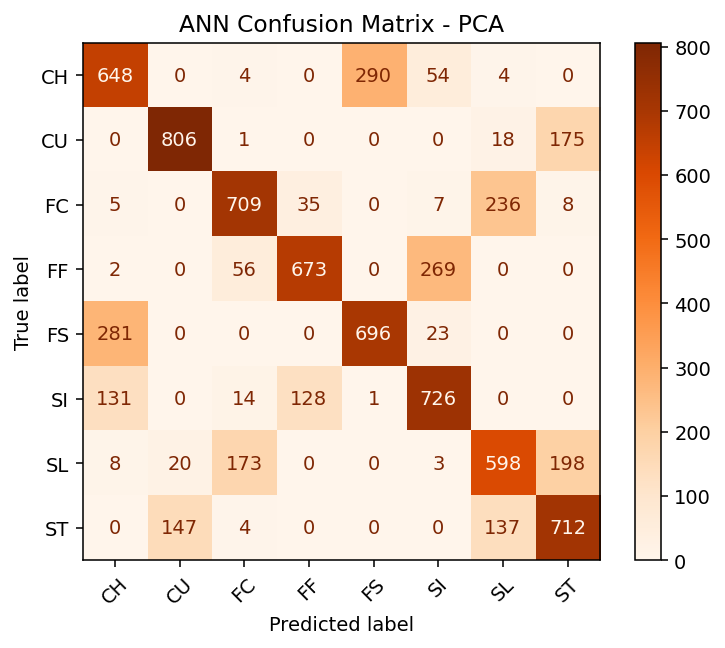

In [ ]:
cm_ann_pca = confusion_matrix(y_true_labels_ann_pca, y_pred_labels_ann_pca)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ann_pca, display_labels=classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Oranges", xticks_rotation=45)
plt.title("ANN Confusion Matrix - PCA")
plt.show()

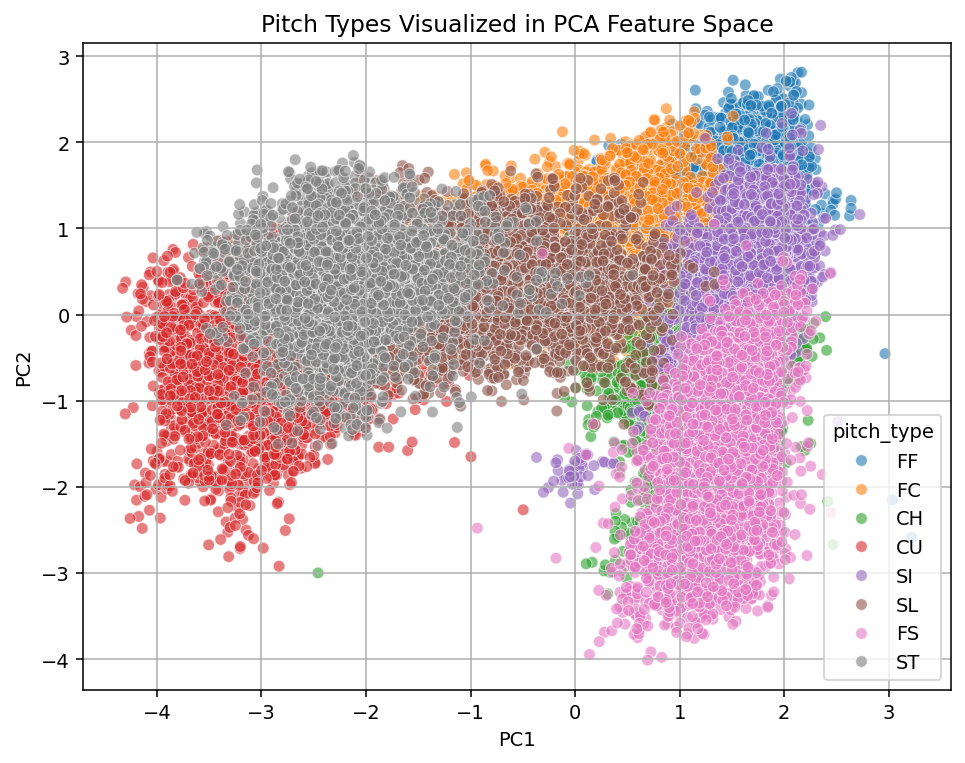

In [ ]:
# Show pitch types in PCA feature space
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numeric_columns])

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

df["pc1"] = pc[:,0]
df["pc2"] = pc[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="pc1",
    y="pc2",
    hue="pitch_type",
    palette="tab10",
    alpha=0.6
)
plt.title("Pitch Types Visualized in PCA Feature Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Ensemble of ANN and KNN


In [22]:

p_ann = ann.predict(X_test_s)
p_knn = knn.predict_proba(X_test_s)

# Ensemble weighting
alpha = 0.5
p_ens = alpha * p_knn + (1 - alpha) * p_ann

y_pred_ens = np.argmax(p_ens, axis=1)
y_true_ens = np.argmax(y_test, axis=1)

acc_ens = accuracy_score(y_true_ens, y_pred_ens)
print(f"\nEnsemble Accuracy (alpha={alpha}): {acc_ens:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_ens, y_pred_ens, target_names=label_encoder.classes_))


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Ensemble Accuracy (alpha=0.5): 0.8397

Classification Report:
              precision    recall  f1-score   support

          CH       0.78      0.78      0.78      1000
          CU       0.92      0.89      0.91      1000
          FC       0.76      0.85      0.80      1000
          FF       0.92      0.93      0.93      1000
          FS       0.82      0.83      0.82      1000
          SI       0.92      0.88      0.90      1000
          SL       0.77      0.65      0.70      1000
          ST       0.83      0.91      0.87      1000

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



<Figure size 1120x840 with 0 Axes>

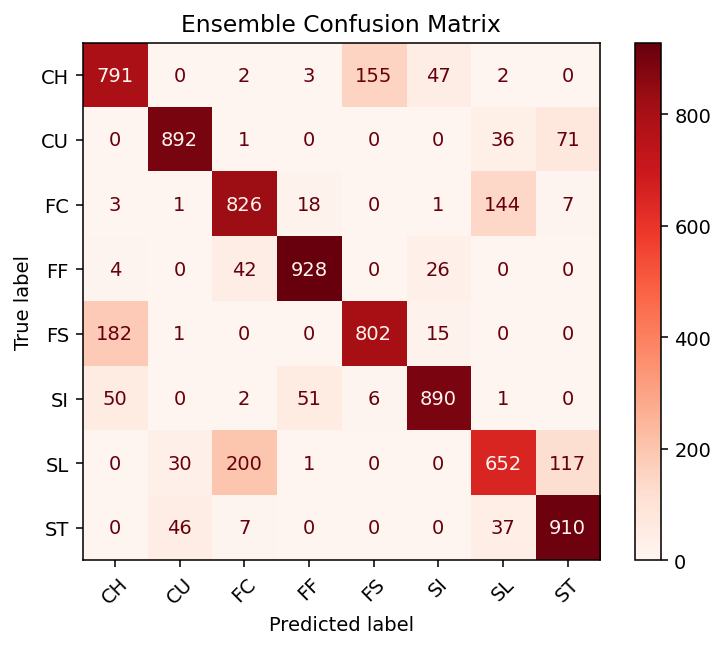

In [ ]:
cm_ens = confusion_matrix(y_true_ens, y_pred_ens)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ens, display_labels=classes)
plt.figure(figsize=(8,6))
disp.plot(cmap="Reds", xticks_rotation=45)
plt.title("Ensemble Confusion Matrix")
plt.show()

# Conclusion

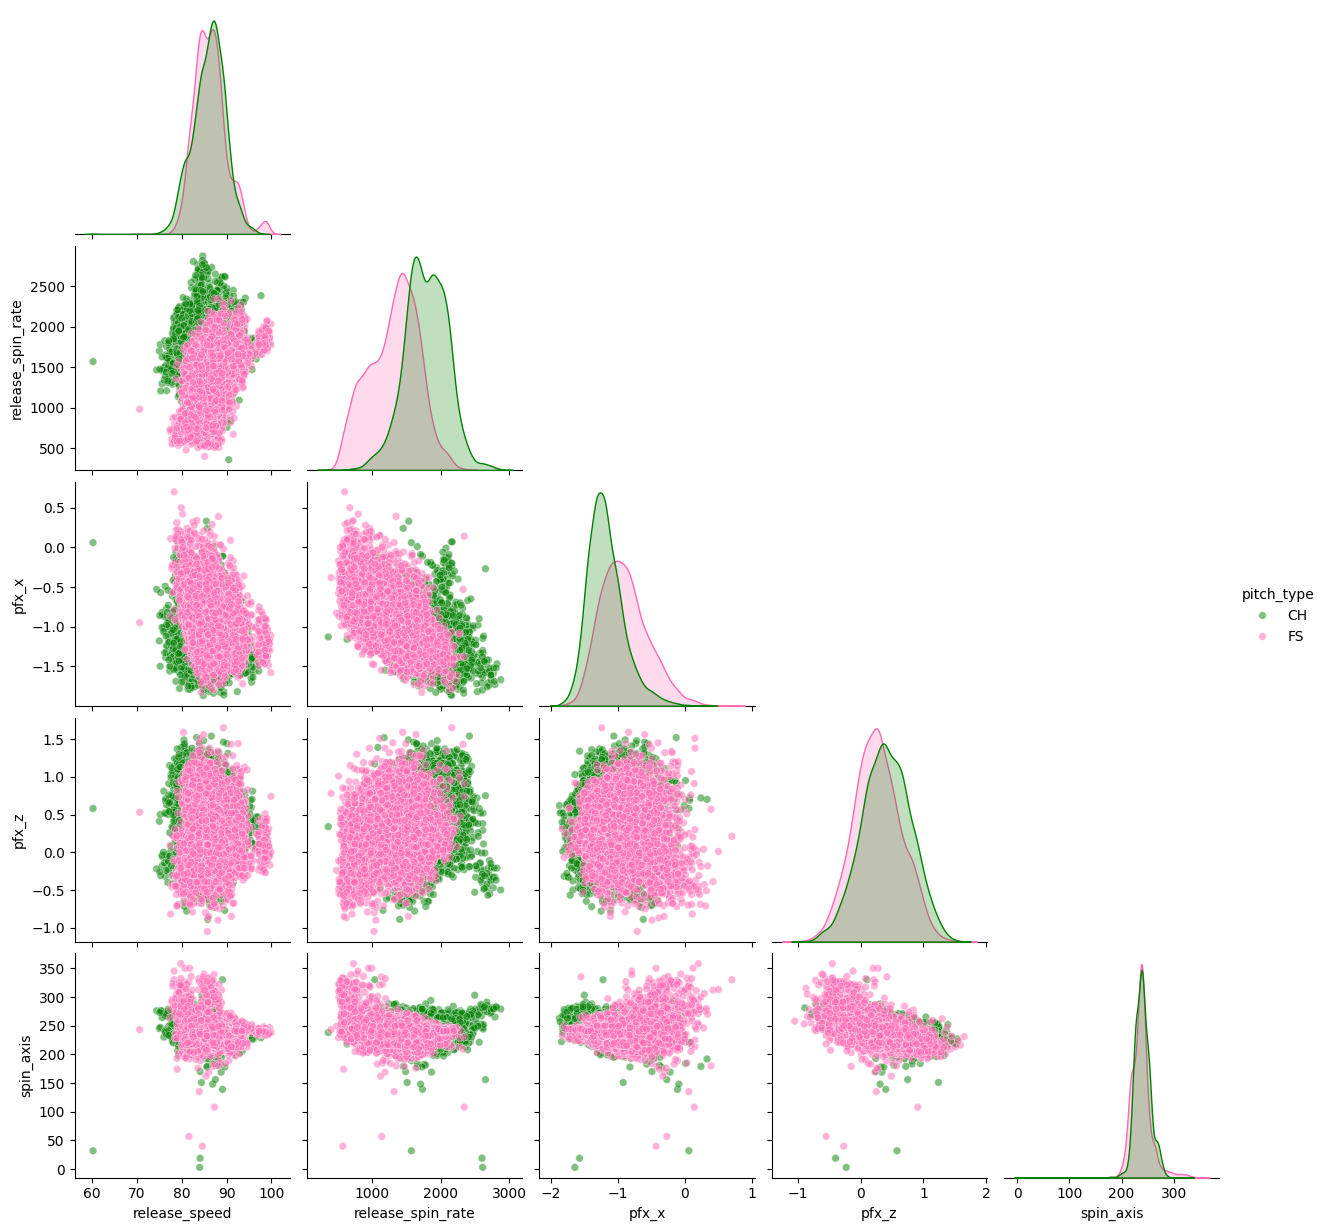

In [ ]:
subset = unnorm_df[df["pitch_type"].isin(["CH", "FS"])]
sns.pairplot(
    subset,
    vars=["release_speed",
          "release_spin_rate",
          "pfx_x","pfx_z",
          "spin_axis"],
    hue="pitch_type",
    palette={"CH": "green",
             "FS": "hotpink"},
    corner=True,
    plot_kws=dict(alpha=0.5, s=30))
plt.show()


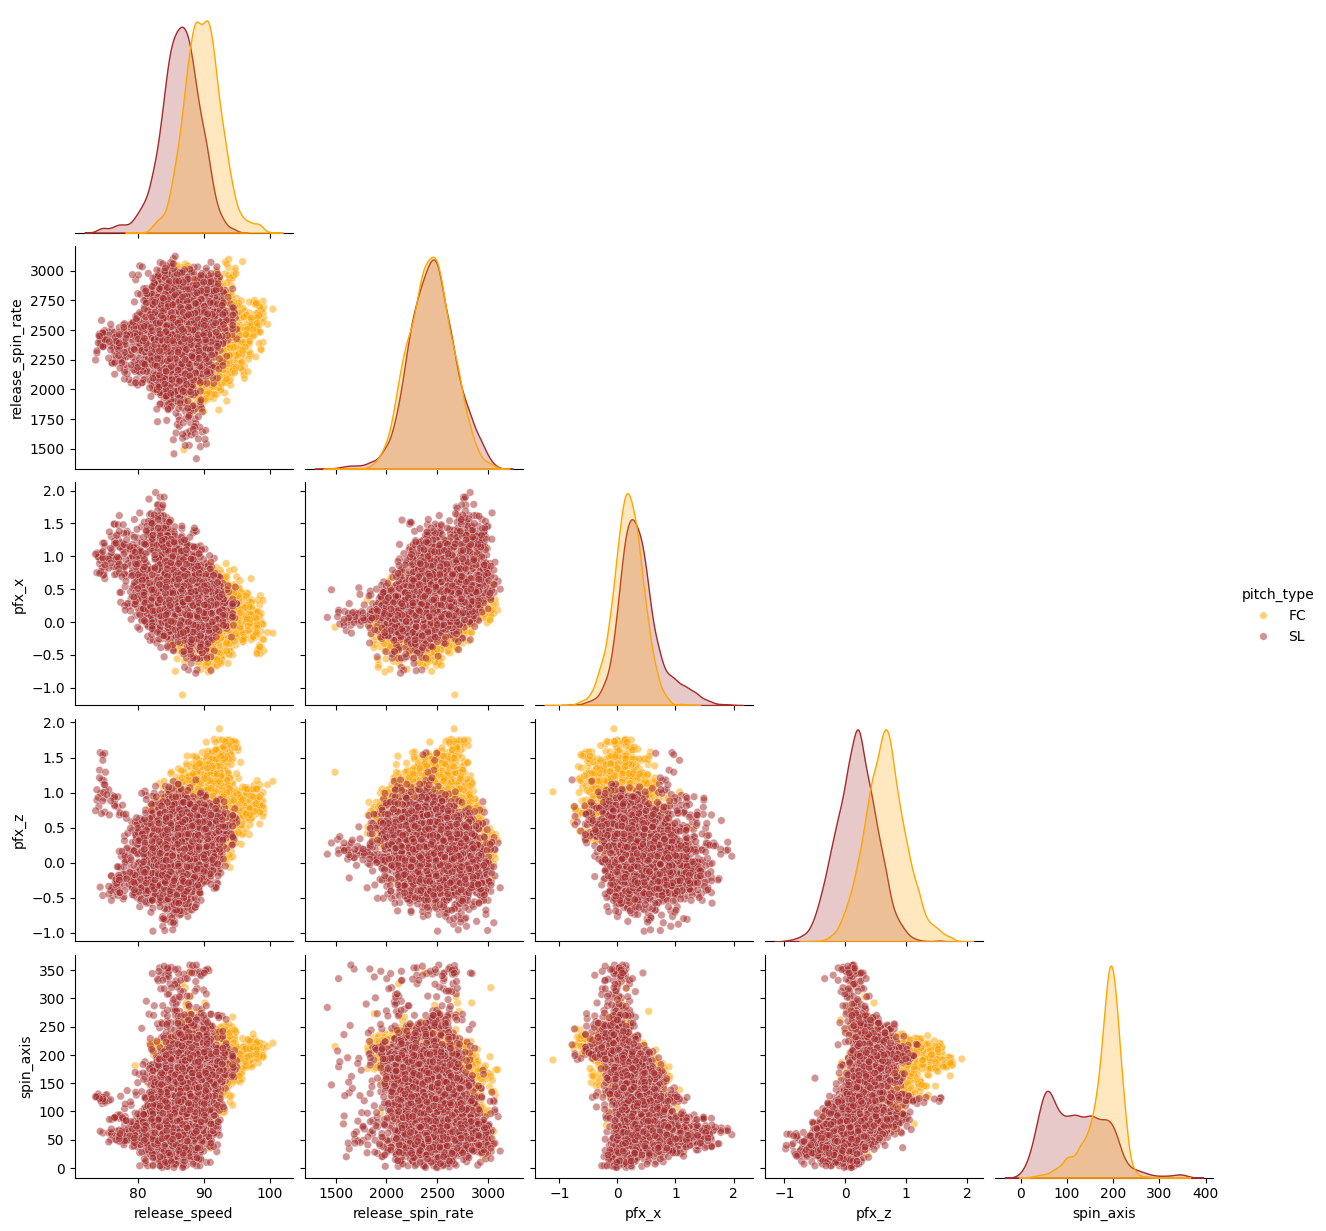

In [ ]:
subset = unnorm_df[df["pitch_type"].isin(["SL", "FC"])]
sns.pairplot(
    subset,
    vars=["release_speed",
          "release_spin_rate",
          "pfx_x","pfx_z",
          "spin_axis"],
    hue="pitch_type",
    palette={"SL": "brown",
             "FC": "orange"},
    corner=True,
    plot_kws=dict(alpha=0.5, s=30))
plt.show()

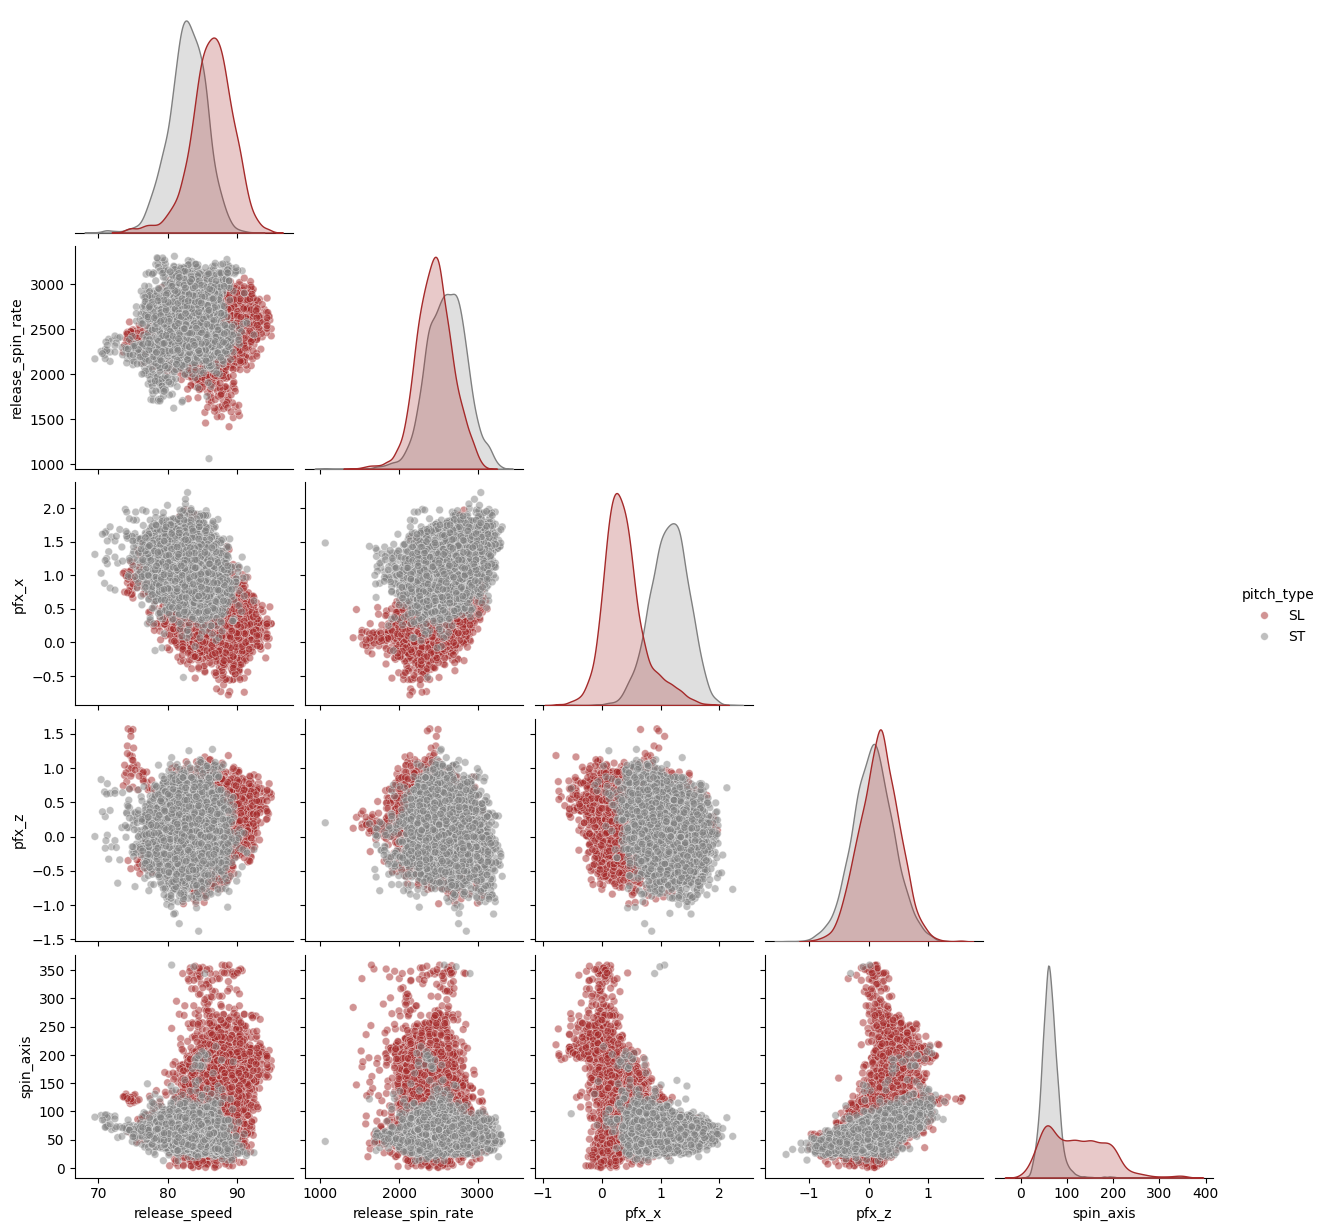

In [ ]:
subset = unnorm_df[df["pitch_type"].isin(["SL", "ST"])]
sns.pairplot(subset, vars=["release_speed","release_spin_rate","pfx_x","pfx_z","spin_axis"], hue="pitch_type", palette={"SL": "brown", "ST": "gray"}, corner=True, plot_kws=dict(alpha=0.5, s=30))
plt.show()